In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

In [4]:
import itertools
from sklearn.model_selection import KFold

In [5]:
sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings

In [6]:
with open('/home/akumar/nse/neural_control/data/sabes_decoding_df.dat', 'rb') as f:
    sabes_df = pickle.load(f)

In [6]:
sabes_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'bin_width', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'dim_vals', 'n_folds',
       'data_file', 'decoder', 'decoder_args', 'decoder_obj', 'r2'],
      dtype='object')

In [29]:
peanut_files = glob.glob('/mnt/Secondary/data/peanut_dimreduc/peanut_dimreduc_*.dat')

In [32]:
p_l = []
for file_ in peanut_files:
    with open(file_, 'rb') as f:
        result = pickle.load(f)

    p_l.extend(result)

In [34]:
peanut_df = pd.DataFrame(p_l)

In [36]:
np.unique(peanut_df['dimreduc_method'].values)

array(['DCA', 'KCA', 'LQGCA', 'PCA'], dtype=object)

In [9]:
# Sabes:
# Organize by (data_file, dim, methods, folds, r2)
data_files = np.unique(sabes_df['data_file'].values)
dims = np.unique(sabes_df['dim'].values)
methods = np.unique(sabes_df['dimreduc_method'].values)

In [10]:
from sklearn.decomposition import PCA

In [11]:
pca_coefs = {}
loader_args = {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100}
for i, data_file in tqdm(enumerate(data_files)):
    dat = load_sabes(data_file, **loader_args, region='M1')
    y = np.squeeze(dat['spike_rates'])
    pcamodel = PCA().fit(y)
    pca_coefs[data_file] = pcamodel.coef_.T

0it [00:00, ?it/s]


NameError: name 'load_sabes' is not defined

In [12]:
# For reference, the task_args:
task_args = [{'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'DCA', 'dimreduc_args': {'T':3, 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'KCA', 'dimreduc_args': {'T':3, 'causal_weights':(1, 0), 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'KCA', 'dimreduc_args': {'T':3, 'causal_weights':(0, 1), 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'KCA', 'dimreduc_args': {'T':3, 'causal_weights':(1, 1), 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'trace', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'fro', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'logdet', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'additive', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'PCA', 'dimreduc_args': {}}]


In [13]:
r2 = np.zeros((len(data_files), dims.size, 9, 5, 3))
for i, data_file in tqdm(enumerate(data_files)):
    for j, dim in enumerate(dims):
        dim_df = apply_df_filters(sabes_df, data_file=data_file, dim=dim)
        for method in methods:
            method_dim_df = apply_df_filters(dim_df, dimreduc_method=method)
            if method == 'PCA':
                pass
                # assert(method_dim_df.shape[0] == 5)
                # for k in range(5):
                #     r2[i, j, 0, k, :] = method_dim_df.iloc[k]['r2']
            elif method == 'DCA':
                assert(method_dim_df.shape[0] == 5)
                for k in range(5):
                    r2[i, j, 1, k, :] = method_dim_df.iloc[k]['r2']
            elif method == 'KCA':
                # Causal weights (1, 0)
                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['causal_weights'] == (1, 0)]
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 2, k, :] = method_dim_df.iloc[idxs[k]]['r2']

                # Causal weights (0, 1)
                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['causal_weights'] == (0, 1)]
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 3, k, :] = method_dim_df.iloc[idxs[k]]['r2']

                # Causal weights (1, 1)
                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['causal_weights'] == (1, 1)]
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 4, k, :] = method_dim_df.iloc[idxs[k]]['r2']

            elif method == 'LQGCA':
                # Trace loss
                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['loss_type'] == 'trace']
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 5, k, :] = method_dim_df.iloc[idxs[k]]['r2']

                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['loss_type'] == 'fro']
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 6, k, :] = method_dim_df.iloc[idxs[k]]['r2']

                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['loss_type'] == 'logdet']
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 7, k, :] = method_dim_df.iloc[idxs[k]]['r2']

                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['loss_type'] == 'additive']
                assert(len(idxs) == 5)
                for k in range(5):
                r2[i, j, 8, k, :] = method_dim_df.iloc[idxs[k]]['r2']


28it [00:10,  2.63it/s]


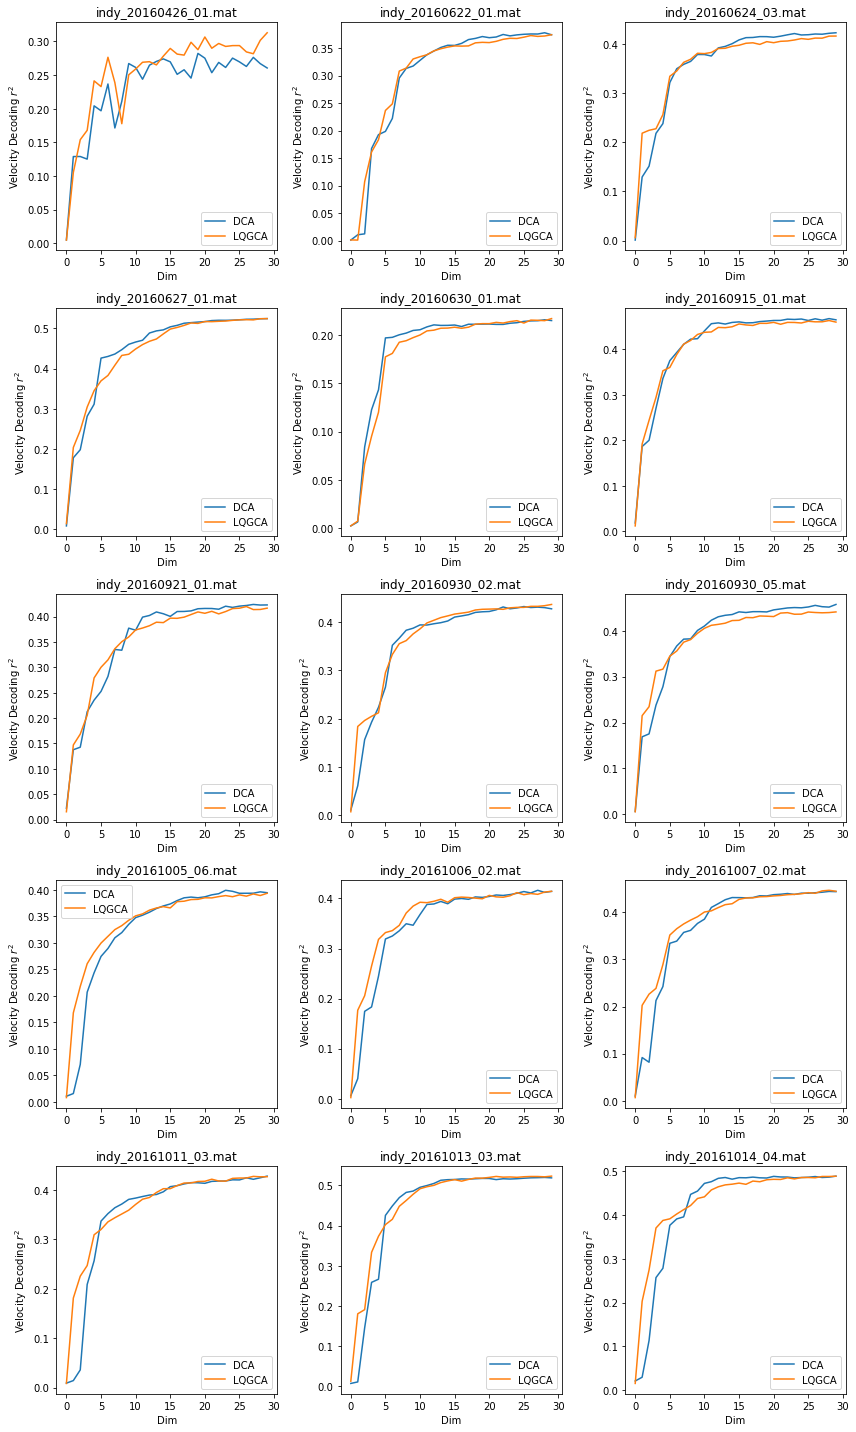

In [14]:
fig, ax = plt.subplots(5, 3, figsize=(12, 20))

for i in range(len(data_files[0:15])):
    a = ax[np.unravel_index(i, (5, 3))]
    
    # PCA
    # a.plot(np.mean(r2[i, :, 0, :, 1], axis=1))
    # DCA
    a.plot(np.mean(r2[i, :, 1, :, 1], axis=1))
    # KCA causal
#    a.plot(np.mean(r2[i, :, 2, :, 1], axis=1))
    # KCA acausal
 #   a.plot(np.mean(r2[i, :, 3, :, 1], axis=1))
    # KCA balanced
#    a.plot(np.mean(r2[i, :, 4, :, 1], axis=1))

    # LQG trace
    a.plot(np.mean(r2[i, :, 5, :, 1], axis=1))

    # LQG frobenius 
#    a.plot(np.mean(r2[i, :, 6, :, 1], axis=1))

    # LQG logdetbut?
#    a.plot(np.mean(r2[i, :, 7, :, 1], axis=1))

    # LQG additive
#    a.plot(np.mean(r2[i, :, 8, :, 1], axis=1))
    a.set_title(data_files[i])
    a.set_xlabel('Dim')
    a.set_ylabel('Velocity Decoding ' + r'$r^2$')

    a.legend(['DCA', 'LQGCA'])

fig.tight_layout()
# fig.savefig('LQGCA_DCA_comparison1.pdf', bbox_inches=0, pad_inches='tight')

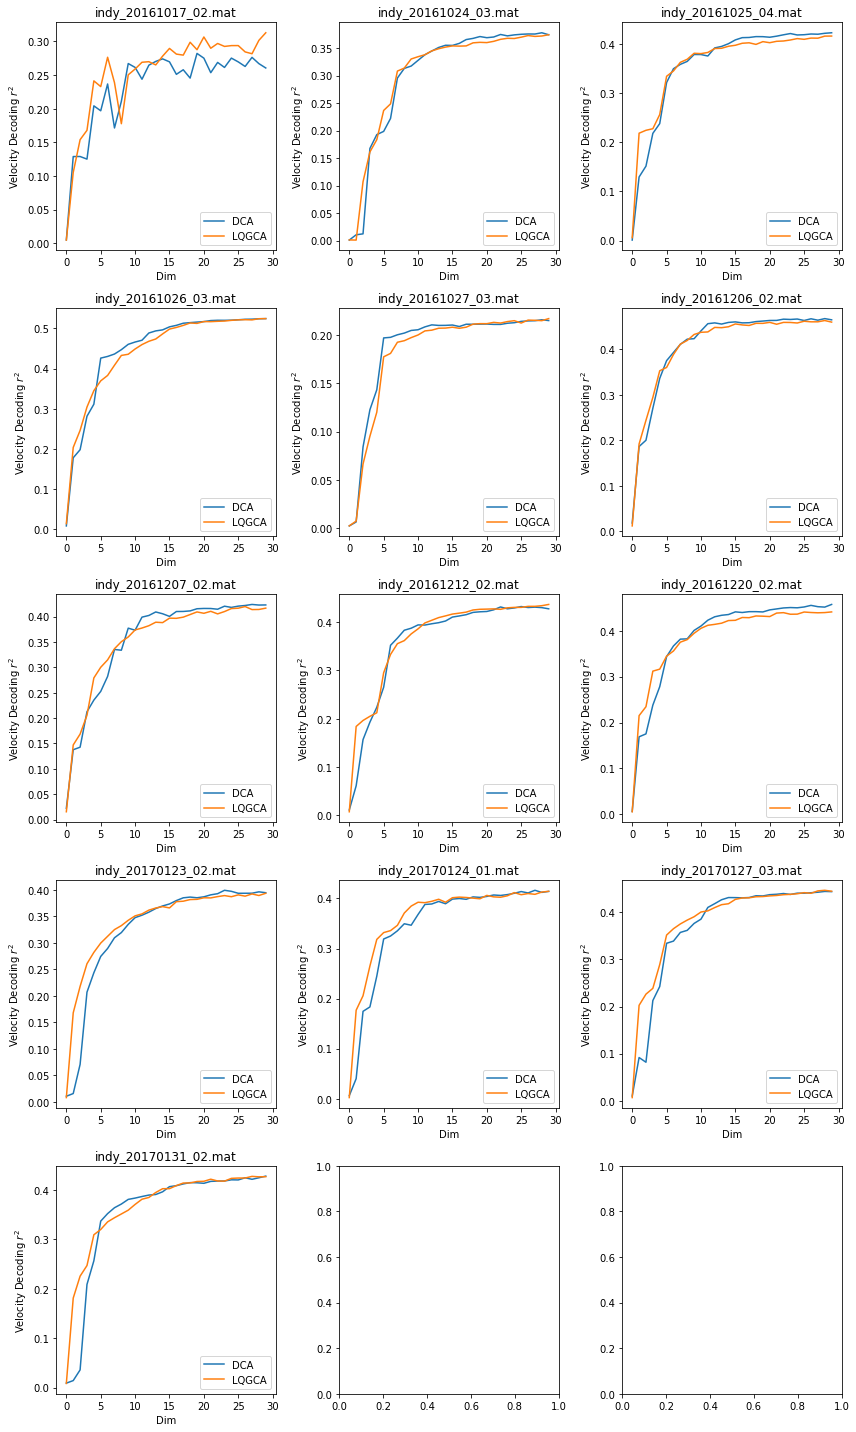

In [17]:
fig, ax = plt.subplots(5, 3, figsize=(12, 20))

for i in range(len(data_files[15:])):
    a = ax[np.unravel_index(i, (5, 3))]
    
    # PCA
    # a.plot(np.mean(r2[i, :, 0, :, 1], axis=1))
    # DCA
    a.plot(np.mean(r2[i, :, 1, :, 1], axis=1))
    # KCA causal
#    a.plot(np.mean(r2[i, :, 2, :, 1], axis=1))
    # KCA acausal
 #   a.plot(np.mean(r2[i, :, 3, :, 1], axis=1))
    # KCA balanced
#    a.plot(np.mean(r2[i, :, 4, :, 1], axis=1))

    # LQG trace
    a.plot(np.mean(r2[i, :, 5, :, 1], axis=1))

    # LQG frobenius 
#    a.plot(np.mean(r2[i, :, 6, :, 1], axis=1))

    # LQG logdetbut?
#    a.plot(np.mean(r2[i, :, 7, :, 1], axis=1))

    # LQG additive
#    a.plot(np.mean(r2[i, :, 8, :, 1], axis=1))
    a.set_title(data_files[i + 15])
    a.set_xlabel('Dim')
    a.set_ylabel('Velocity Decoding ' + r'$r^2$')

    a.legend(['DCA', 'LQGCA'])

fig.tight_layout()
fig.savefig('LQGCA_DCA_comparison2.pdf', bbox_inches=0, pad_inches='tight')

In [33]:
# Does difference to the supervised subspace consistently decrease across methods as decoding performance increases?
with open('/home/akumar/nse/neural_control/data/sabes_supervised_decoding.dat', 'rb') as f:
    sabes_supervised_df = pickle.load(f)

In [34]:
sabes_supervised_df.keys()

Index(['data_file', 'coef', 'loadings', 'trainlag', 'testlag',
       'decoding_window', 'bin_width', 'filter_fn', 'filter_kwargs', 'boxcox',
       'spike_threshold', 'fold_idx'],
      dtype='object')

In [41]:
# Subspace angles : (data_file, n_folds, method, dim)
lc = np.zeros((len(data_files), 5, 8, dims.size))

for i, data_file in enumerate(data_files):
    for j in range(5):
        sdf = apply_df_filters(sabes_supervised_df, data_file=data_file, fold_idx=j)
        for k, dim in enumerate(dims):
            for method in methods:
                method_df = apply_df_filters(sabes_df, dimreduc_method=method, data_file=data_file, dim=dim, fold_idx=j)
                if method == 'DCA':
                    lc[i, j, 0, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[0]['coef']))[0]
                elif method == 'KCA':
                    # Causal weights (1, 0)
                    idxs = [idx for idx in range(method_df.shape[0]) if method_df.iloc[idx]['dimreduc_args']['causal_weights'] == (1, 0)]
                    assert(len(idxs) == 1)
                    lc[i, j, 1, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[idxs[0]]['coef']))[0]

                    # Causal weights (0, 1)
                    idxs = [idx for idx in range(method_df.shape[0]) if method_df.iloc[idx]['dimreduc_args']['causal_weights'] == (0, 1)]
                    assert(len(idxs) == 1)
                    lc[i, j, 2, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[idxs[0]]['coef']))[0]

                    # Causal weights (1, 1)
                    idxs = [idx for idx in range(method_df.shape[0]) if method_df.iloc[idx]['dimreduc_args']['causal_weights'] == (1, 1)]
                    assert(len(idxs) == 1)
                    lc[i, j, 3, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[idxs[0]]['coef']))[0]

                elif method == 'LQGCA':
                    # Trace loss
                    idxs = [idx for idx in range(method_df.shape[0]) if method_df.iloc[idx]['dimreduc_args']['loss_type'] == 'trace']
                    assert(len(idxs) == 1)
                    lc[i, j, 4, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[idxs[0]]['coef']))[0]

                    idxs = [idx for idx in range(method_df.shape[0]) if method_df.iloc[idx]['dimreduc_args']['loss_type'] == 'fro']
                    assert(len(idxs) == 1)
                    lc[i, j, 5, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[idxs[0]]['coef']))[0]

                    idxs = [idx for idx in range(method_df.shape[0]) if method_df.iloc[idx]['dimreduc_args']['loss_type'] == 'logdet']
                    assert(len(idxs) == 1)
                    lc[i, j, 6, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[idxs[0]]['coef']))[0]

                    idxs = [idx for idx in range(method_df.shape[0]) if method_df.iloc[idx]['dimreduc_args']['loss_type'] == 'additive']
                    assert(len(idxs) == 1)
                    lc[i, j, 7, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[idxs[0]]['coef']))[0]



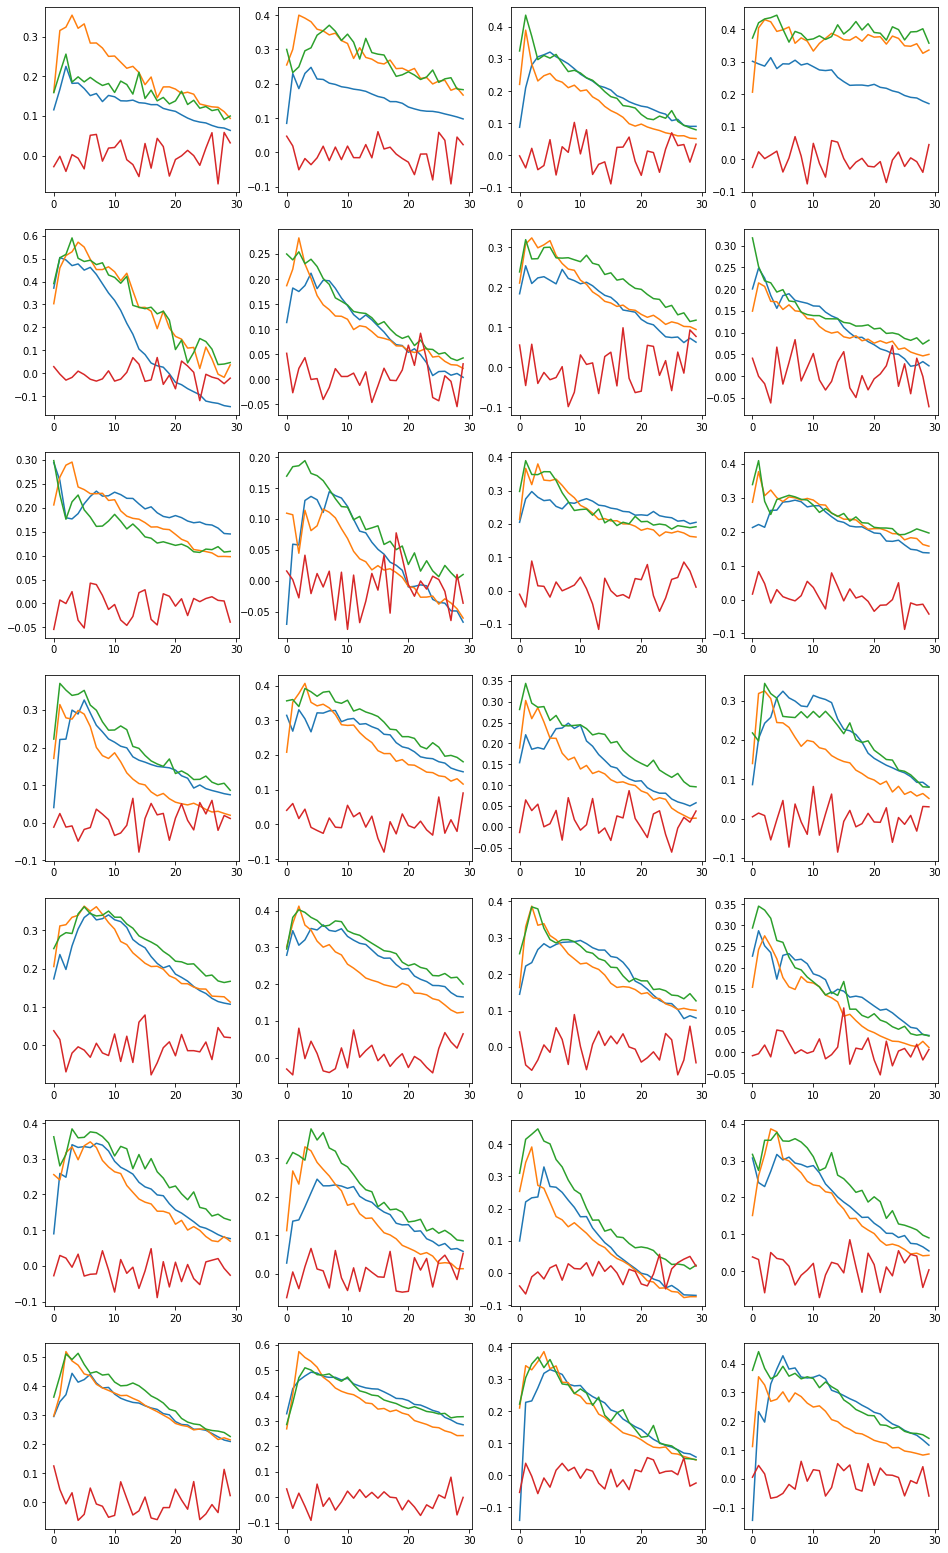

In [42]:
fig, ax = plt.subplots(7, 4, figsize=(16, 28))

for i in range(len(data_files)):
    a = ax[np.unravel_index(i, (7, 4))]
    
    # PCA
#    a.plot(np.mean(r2[i, :, 0, :, 1], axis=1))
    # DCA
    a.plot(np.mean(lc[i, :, 0, :], axis=0))
    # KCA causal
    a.plot(np.mean(lc[i, :, 1, :], axis=0))
    # KCA acausal
 #   a.plot(np.mean(r2[i, :, 3, :, 1], axis=1))
    # KCA balanced
#    a.plot(np.mean(r2[i, :, 4, :, 1], axis=1))

    # LQG trace
    a.plot(np.mean(lc[i, :, 4, :], axis=0))

    # LQG frobenius 
    a.plot(np.mean(lc[i, :, 6, :], axis=0))

    # LQG logdetbut?
#    a.plot(np.mean(r2[i, :, 7, :, 1], axis=1))

    # LQG additive
#    a.plot(np.mean(r2[i, :, 8, :, 1], axis=1))



In [ ]:
# How do we measure the subspace angles themselves? Seems to require fitting methods on the lagged state space

### Proximity to supervised subspace

Consolidate

In [6]:
import glob
import pickle

In [7]:
decoding_files = glob.glob('/mnt/Secondary/data/sabes_decoding_lag5/sabes_decoding_lag5_*.dat')

In [8]:
results_list = []
for file in decoding_files:
    with open(file, 'rb') as f:
        result = pickle.load(f)
    results_list.extend(result)


/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [13]:
sabes_lag5_df = pd.DataFrame(results_list)

In [14]:
sabes_lag5_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'lag', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'bin_width', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'dim_vals', 'n_folds',
       'data_file', 'decoder', 'decoder_args', 'decoder_obj', 'r2'],
      dtype='object')

In [21]:
data_files = np.unique(sabes_lag5_df['data_file'].values)
dims = np.unique(sabes_lag5_df['dim'].values)
methods = np.unique(sabes_lag5_df['dimreduc_method'].values)

In [27]:
r2 = np.zeros((len(data_files), dims.size, 5, 5, 3))
for i, data_file in tqdm(enumerate(data_files)):
    for j, dim in enumerate(dims):
        dim_df = apply_df_filters(sabes_lag5_df, data_file=data_file, dim=dim)
        for method in methods:
            method_dim_df = apply_df_filters(dim_df, dimreduc_method=method)
            if method == 'PCA':
                assert(method_dim_df.shape[0] == 5)
                for k in range(5):
                    r2[i, j, 0, k, :] = method_dim_df.iloc[k]['r2']
            elif method == 'DCA':
                assert(method_dim_df.shape[0] == 5)
                for k in range(5):
                    r2[i, j, 1, k, :] = method_dim_df.iloc[k]['r2']
            elif method == 'KCA':
                # Causal weights (1, 0)
                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['causal_weights'] == (1, 0)]
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 2, k, :] = method_dim_df.iloc[idxs[k]]['r2']

            elif method == 'LQGCA':
                # Trace loss
                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['loss_type'] == 'trace']
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 3, k, :] = method_dim_df.iloc[idxs[k]]['r2']

                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['loss_type'] == 'logdet']
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 4, k, :] = method_dim_df.iloc[idxs[k]]['r2']


    

28it [00:04,  6.69it/s]


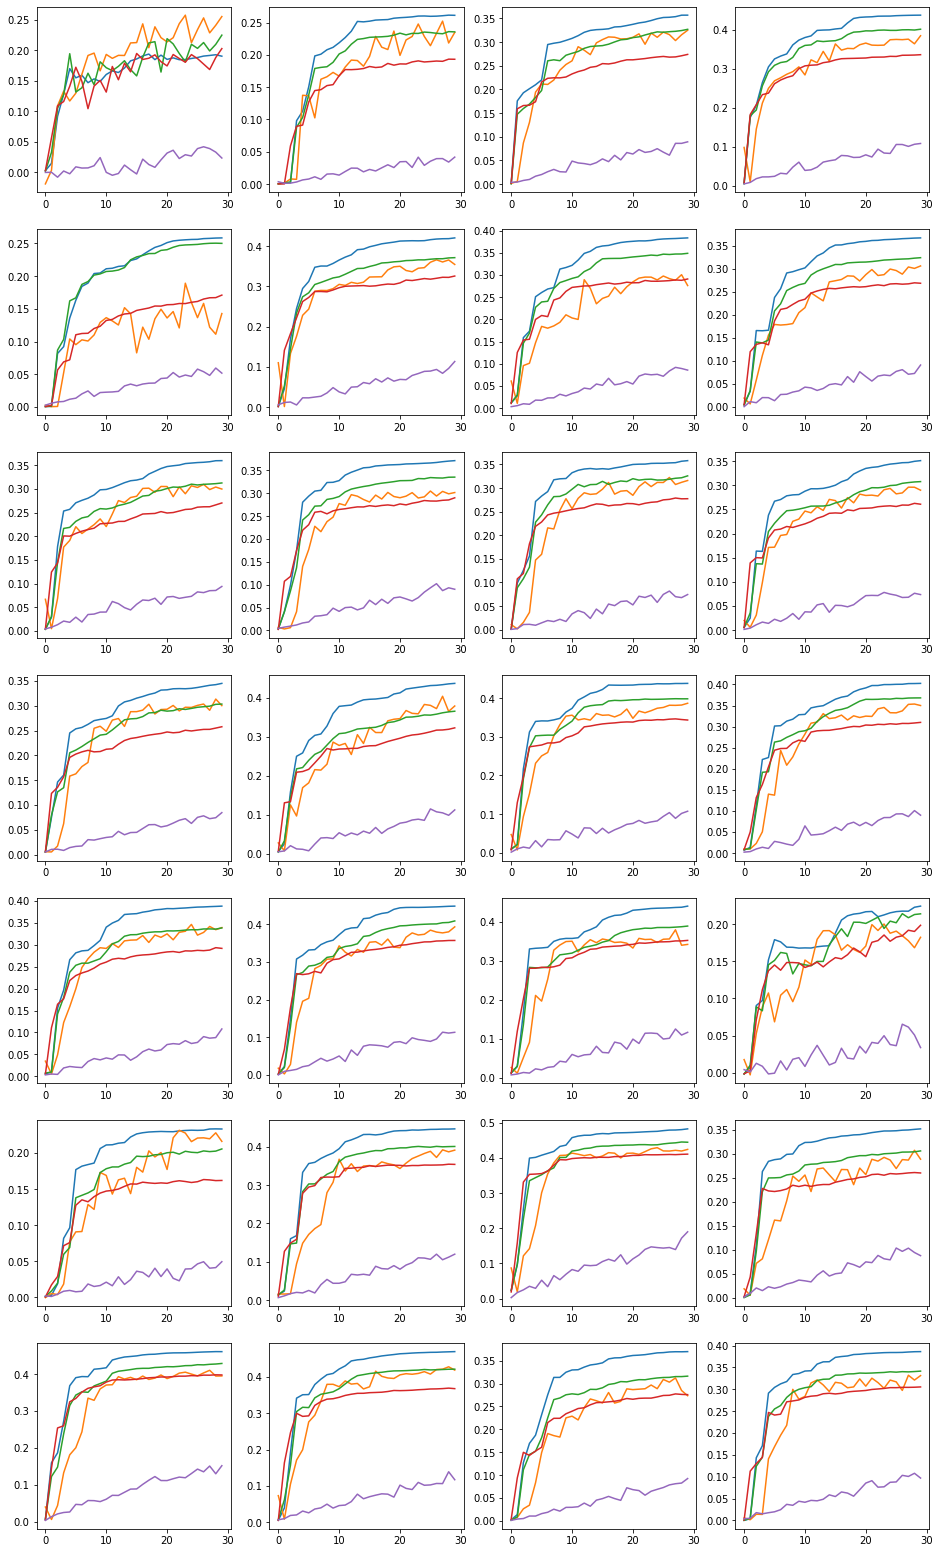

In [28]:
fig, ax = plt.subplots(7, 4, figsize=(16, 28))

for i in range(len(data_files)):
    a = ax[np.unravel_index(i, (7, 4))]
    
#    PCA
    a.plot(np.mean(r2[i, :, 0, :, 1], axis=1))
    # DCA
    a.plot(np.mean(r2[i, :, 1, :, 1], axis=1))
#    KCA causal
    a.plot(np.mean(r2[i, :, 2, :, 1], axis=1))

    # LQG trace
    a.plot(np.mean(r2[i, :, 3, :, 1], axis=1))

    # LQG logdet
    a.plot(np.mean(r2[i, :, 4, :, 1], axis=1))



### Make nice plots for group meeting

In [7]:

peanut_decoding_files = glob.glob('/mnt/Secondary/data/cosyne_results/peanut_decoding/peanut_decoding_*.dat')
peanut_kca_files = glob.glob('/mnt/Secondary/data/cosyne_results/peanut_kca/peanut_kca_*.dat')            

In [19]:
# Grab PCA results
with open('/home/akumar/nse/neural_control/data/sabes_kca_decodign_df.dat', 'rb') as f:
    sabes_decoding_df = pickle.load(f)

In [20]:
sabes_decoding_df.keys()

Index(['dim', 'fold_idx', 'dr_method', 'decoder', 'decoder_args',
       'decoder_obj', 'r2', 'data_file', 'bin_width', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'trainlag', 'testlag',
       'decoding_window'],
      dtype='object')

In [15]:
dim_vals = np.unique(sabes_df['dim'].values)
data_files = np.unique(sabes_df['data_file'].values)

In [22]:
sr2_vel_pca = np.zeros((28, 30, 5))
for i, data_file in enumerate(data_files):
    for j, dim in enumerate(dim_vals):
        pca_df = apply_df_filters(sabes_decoding_df, dim=dim, data_file=data_file, dr_method='PCA')
        for k in range(pca_df.shape[0]):
            sr2_vel_pca[i, j, k] = pca_df.iloc[k]['r2'][1]

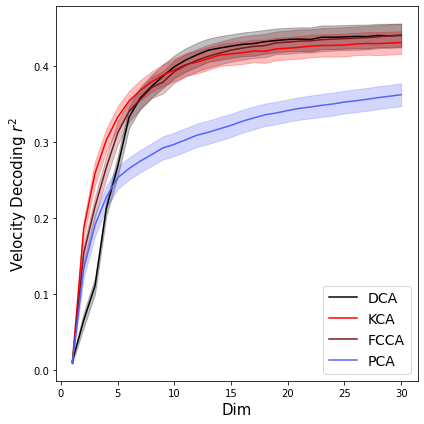

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Average across folds and plot
# REINSERT OLS(5) IN HERE IF NEEDED

colors = ['black', 'red', '#781820', '#5563fa']


# DCA averaged over folds
dca_r2 = np.mean(r2[:, :, 1, :, 1], axis=2)
# KCA averaged over folds
kca_r2 = np.mean(r2[:, :, 2, :, 1], axis=2)
# FCCA averaged over folds
fca_r2 = np.mean(r2[:, :, 5, :, 1], axis=2)
# PCA
pca_r2 = np.mean(sr2_vel_pca, axis=-1)

ax.fill_between(dim_vals, np.mean(dca_r2, axis=0) + np.std(dca_r2, axis=0)/np.sqrt(28),
                np.mean(dca_r2, axis=0) - np.std(dca_r2, axis=0)/np.sqrt(28), color=colors[0], alpha=0.25)
ax.plot(dim_vals, np.mean(dca_r2, axis=0), color=colors[0])
ax.fill_between(dim_vals, np.mean(kca_r2, axis=0) + np.std(kca_r2, axis=0)/np.sqrt(28),
                np.mean(kca_r2, axis=0) - np.std(kca_r2, axis=0)/np.sqrt(28), color=colors[1], alpha=0.25)
ax.plot(dim_vals, np.mean(kca_r2, axis=0), color=colors[1])
ax.fill_between(dim_vals, np.mean(fca_r2, axis=0) + np.std(fca_r2, axis=0)/np.sqrt(28),
                np.mean(fca_r2, axis=0) - np.std(fca_r2, axis=0)/np.sqrt(28), color=colors[2], alpha=0.25)
ax.plot(dim_vals, np.mean(fca_r2, axis=0), color=colors[2])

ax.fill_between(dim_vals, np.mean(pca_r2, axis=0) + np.std(pca_r2, axis=0)/np.sqrt(28),
                np.mean(pca_r2, axis=0) - np.std(pca_r2, axis=0)/np.sqrt(28), color=colors[3], alpha=0.25)
ax.plot(dim_vals, np.mean(pca_r2, axis=0), color=colors[3])

ax.set_xlabel('Dim', fontsize=15)
ax.set_ylabel('Velocity Decoding ' + r'$r^2$', fontsize=15)

ax.legend(['DCA', 'KCA', 'FCCA', 'PCA'], loc='lower right', fontsize=14)
fig.tight_layout()
fig.savefig('decoding_averaged.pdf', bbox_inches='tight', pad_inches=0)